In [1]:
from hist_functions import *
import os
import pandas as pd

def update_dict(dict, key):
    if key in dict:
        dict[key] += 1
    else:
        dict[key] = 1

def plot_dict_dist(dist_dict, title):
    # Extract the keys and values from the dictionary
    keys = list(dist_dict.keys())
    counts = list(dist_dict.values())

    # Create the bar plot
    # plt.figure(figsize=(14, 4))
    plt.figure()
    plt.bar(keys, counts)

    plt.title(f'Distribution of {title}')
    plt.xlabel(title)
    plt.ylabel('Counts')
    plt.grid()
    plt.show()

In [12]:
import music21

def frequency_to_note_number(freq):
    """Convert frequency to a floating-point MIDI note number."""
    return 69 + 12 * np.log2(freq / 440.0)

def frequency_to_note_name(freq):
    """Convert a frequency in Hz to a MIDI note number."""
    note_number = frequency_to_note_number(freq)
    notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    return notes[int(round(note_number)) % 12]


def get_scale(key, mode_name):
    """
    Generates a scale based on a given key and mode name, returns note names without octaves,
    converting flats to their enharmonic sharp equivalents where possible.
    """
    mode_name = mode_name.lower()
    if mode_name == "major":
        scl = music21.scale.MajorScale(key)
    elif mode_name == "minor":
        scl = music21.scale.MinorScale(key)  # Ensure using NaturalMinorScale for minor
    else:
        raise ValueError(f"Unsupported mode: {mode_name}")

    # Get all pitches in the scale within one octave
    notes = scl.getPitches(key + "4", key + "5")
    
    # Convert all notes to their enharmonic equivalents where applicable and convert to sharp notation
    sharp_notes = []
    for n in notes:
        p = music21.pitch.Pitch(n)
        # Get enharmonic if the note has a flat, otherwise just take the sharp directly
        if '-' in p.name:
            enharmonic = p.getEnharmonic()
            sharp_notes.append(enharmonic.nameWithOctave)
        else:
            sharp_notes.append(p.nameWithOctave)

    # Convert E# to F and B# to C
    conversion_map = {'E#': 'F', 'B#': 'C'}
    final_notes = []
    for note in sharp_notes:
        base_note = note[:-1]  # Remove the octave number
        final_note = conversion_map.get(base_note, base_note)  # Convert if necessary
        final_notes.append(final_note)
    
    return final_notes


def is_in_scale(note_name, scale):
    """Check if a given note name is in the B major scale."""
    return note_name in scale


def adjust_pitch_to_scale_octave(pitch_hz, scale_midi):
    """
    Convert a pitch in Hz to the closest MIDI number within the octave of a given scale.
    """
    # Convert pitch in Hz to MIDI number
    pitch_midi = librosa.hz_to_midi(pitch_hz)
    
    # Determine the octave of the scale
    min_midi = min(scale_midi)  # Find the lowest MIDI note in the scale
    octave_start = min_midi - (min_midi % 12)  # Find the start of the octave for the scale

    # Adjust the pitch MIDI to the octave of the scale
    adjusted_pitch_midi = octave_start + (pitch_midi % 12)

    # Optional: Ensure the adjusted MIDI is in the range of the scale's octave
    if adjusted_pitch_midi < min_midi:
        adjusted_pitch_midi += 12
    elif adjusted_pitch_midi > max(scale_midi):
        adjusted_pitch_midi -= 12

    return adjusted_pitch_midi


def find_min_dist(pitch, scale):
    scale_midi = librosa.note_to_midi(scale)
    pitch_midi = adjust_pitch_to_scale_octave(pitch_hz=pitch, scale_midi=scale_midi)
    return min([abs(pitch_midi - i) for i in scale_midi])


def count_tonality_pitches(pitches, key, mode, note_distribution, penalty):
    """
    Count how many pitches in the array are part of the B major scale.
    penalty: if not in scale, give penalty according to distance to closest note in scale
    """
    count = 0
    scale = get_scale(key, mode)
    print(get_scale(key, mode))

    for pitch in pitches:
        note_name = frequency_to_note_name(pitch)
        update_dict(note_distribution, note_name)

        if is_in_scale(note_name, scale):
            count += 1
        elif penalty:
            # Compute penalty
            min_dist = find_min_dist(pitch, scale)
            print(f'min_dist = {min_dist}')
            if min_dist <= 0.5:
                # 50 cents
                count -= 1
            else:
                # 100 cents
                count -= 2
    return count



def compute_tonality_score(pitch, key, mode, note_distribution, penalty=False):
    # Compute number of pitches in B major scale
    voiced_pitch = pitch[np.where(pitch != 0)]
    count = count_tonality_pitches(voiced_pitch, key, mode, note_distribution, penalty)
    # Normalize
    obj_score = count / len(voiced_pitch)

    return obj_score

# Example usage
test_pitches = [440, 493.88, 523.25, 587.33, 659.25, 739.99, 783.99, 987.77]  # Example frequencies in Hz
print(librosa.hz_to_note(test_pitches))

test_note_dist = {}
count = count_tonality_pitches(test_pitches, 'Bb', 'major', test_note_dist, penalty=False)
print("Number of pitches in B major scale:", count)
count = count_tonality_pitches(test_pitches, 'G', 'minor', test_note_dist, penalty=False)
print("Number of pitches in Db major scale:", count)


['A4' 'B4' 'C5' 'D5' 'E5' 'F♯5' 'G5' 'B5']
['A#', 'C', 'D', 'D#', 'F', 'G', 'A', 'A#']
Number of pitches in B major scale: 4
['G', 'A', 'A#', 'C', 'D', 'D#', 'F', 'G']
Number of pitches in Db major scale: 4


Single Song Test

['G#', 'A#', 'B', 'C#', 'D#', 'E', 'F#', 'G#']
{'D#': 45, 'D': 13, 'A': 2, 'A#': 3, 'B': 16, 'C': 181, 'C#': 99, 'F#': 48, 'G': 5, 'F': 1, 'E': 15}


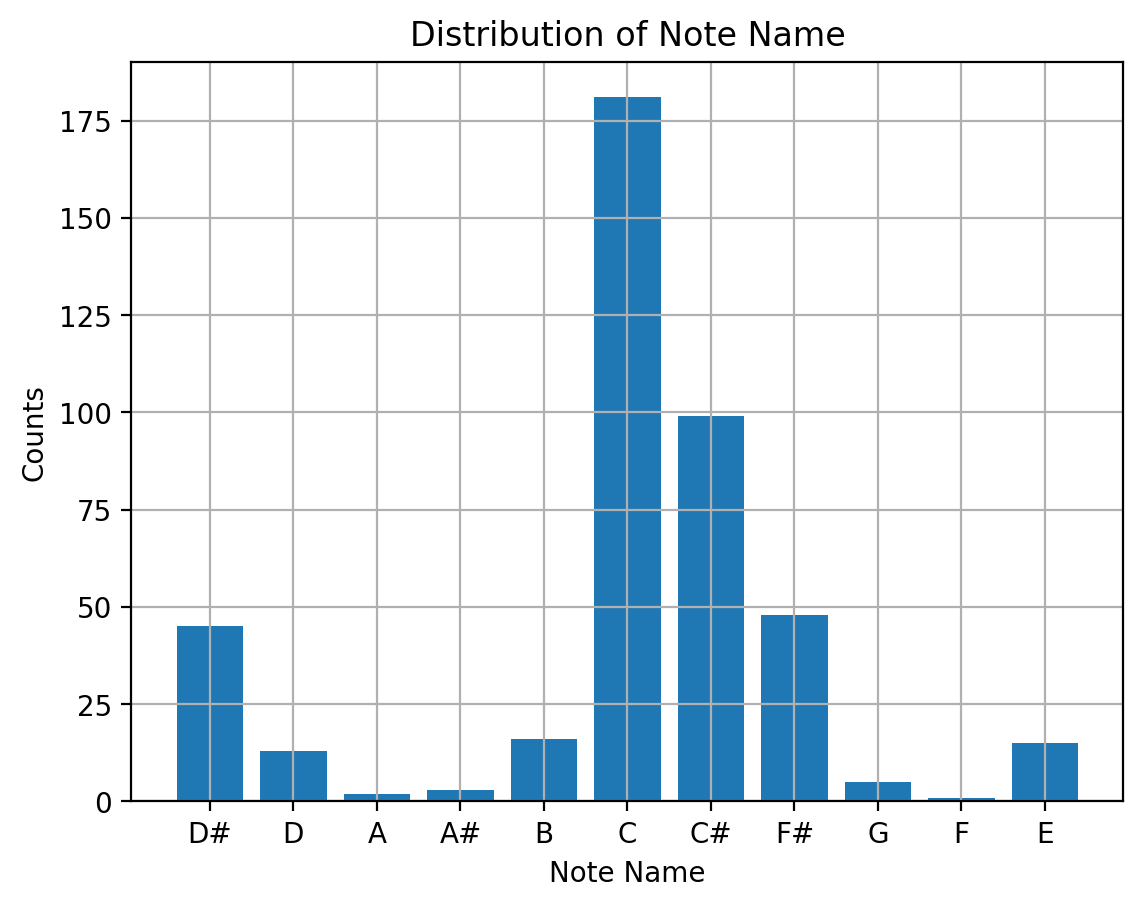

score: 0.5280373831775701
['G#', 'A#', 'B', 'C#', 'D#', 'E', 'F#', 'G#']
{'D#': 51, 'D': 7, 'C#': 84, 'C': 76, 'B': 65, 'F#': 48, 'F': 3, 'G': 10, 'A': 3, 'A#': 16, 'E': 10, 'G#': 1}


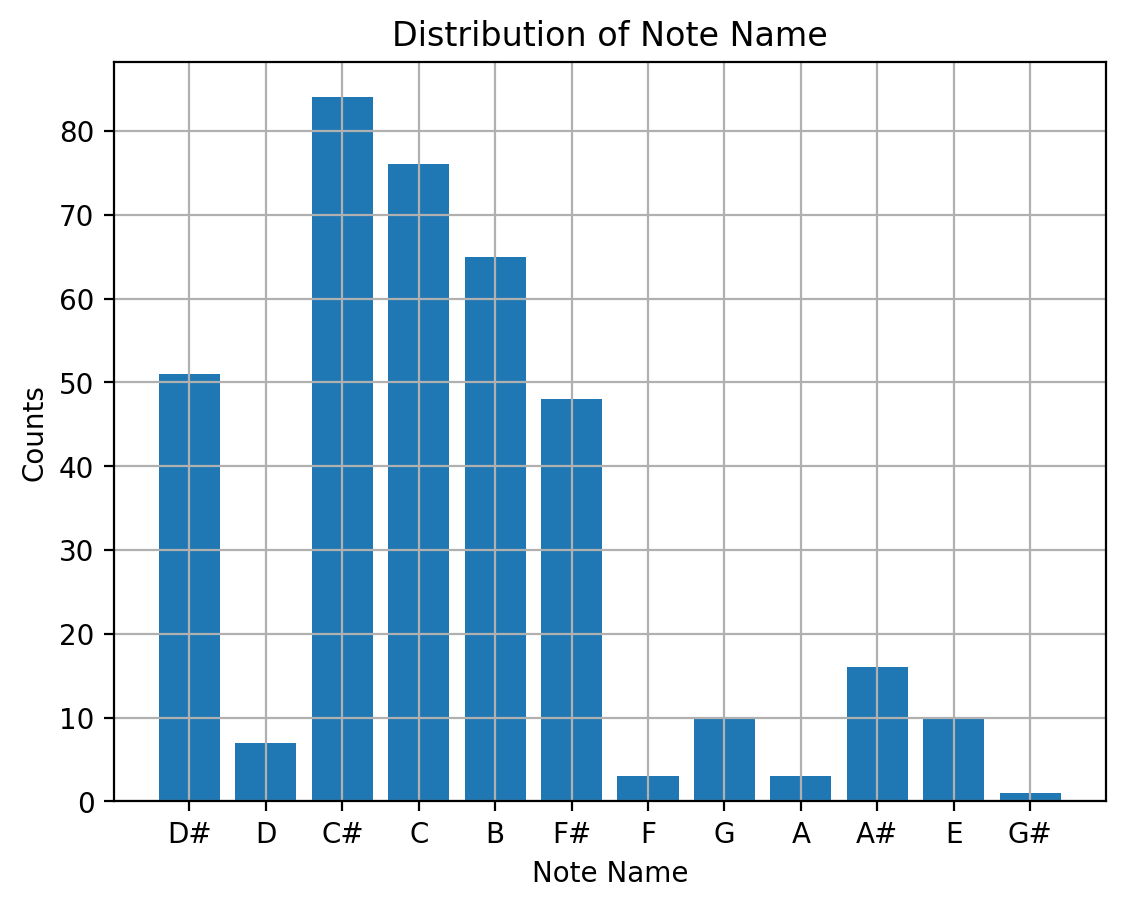

score: 0.7352941176470589


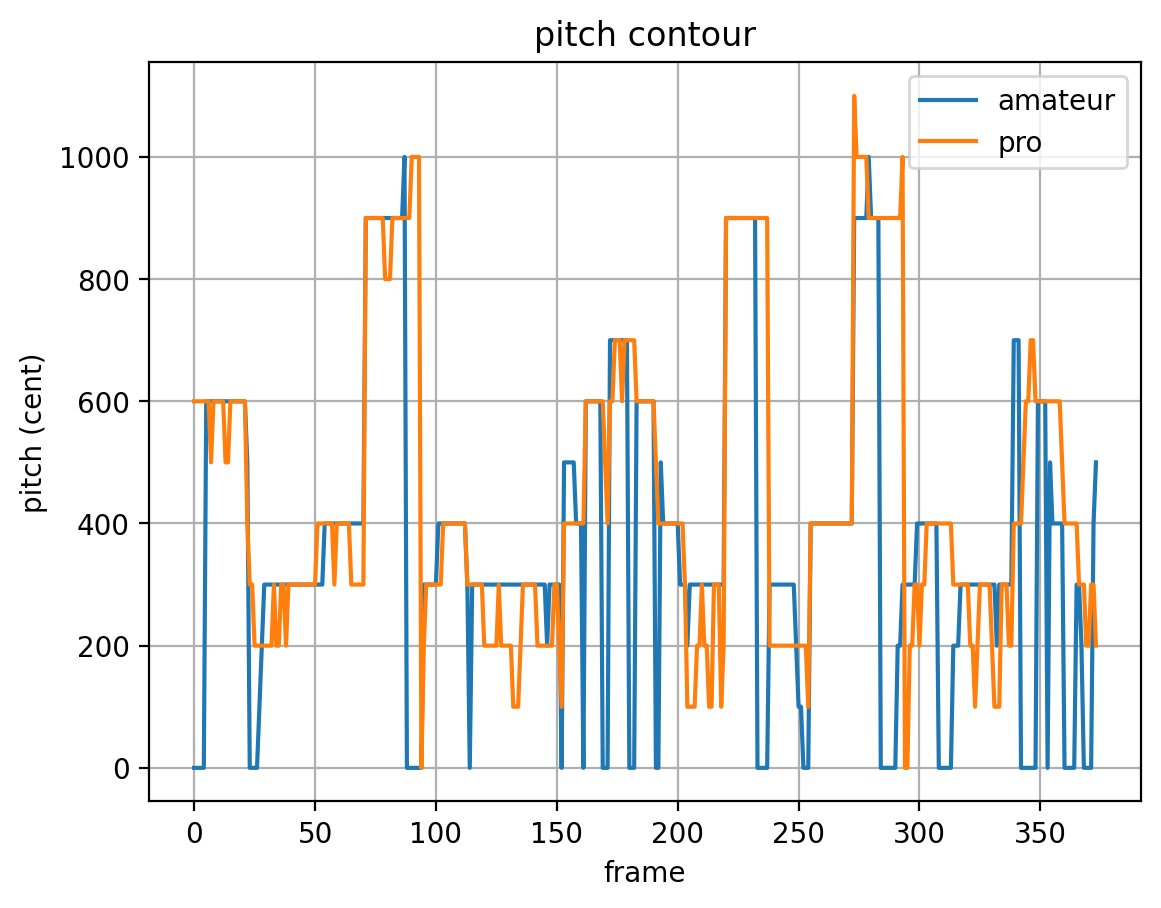

In [ ]:
songname = 'vocal_estimated_34_predict.txt'
test_pitch = np.loadtxt('listening_test/predict_result/'+songname)

test_note_distribution = {}
test_obj_score = compute_tonality_score(test_pitch, 'Ab', 'minor', test_note_distribution, penalty=False)
print(test_note_distribution)
plot_dict_dist(test_note_distribution, 'Note Name')
print(f'score: {test_obj_score}')
# plot_contour(test_pitch, unit='hz')

test_cent, voiced = quantize_pitch(test_pitch, resolution_cents=100)

fold_into_octave(test_cent)
x = np.arange(len(voiced))
plt.plot(x, test_cent[voiced], label='amateur')
plt.title('pitch contour')
plt.xlabel('frame')
plt.ylabel('pitch (cent)')
plt.grid()
plt.legend()
plt.show()



In [7]:
import re

def sort_files(l):
    """ Sorts the given iterable numerically"""
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)



Tunebat

In [ ]:
# # vocal_folder = 'listening_test/first/predict_result/'
# # vocal_folder = 'listening_test/second/predict_result/'
# target_folder = 'obj_score'

# # Get a list of file names within the directory
# files = os.listdir(vocal_folder)
# sorted_files = sort_files(files)

# sheet_path = 'key_list/key_tunebat.xlsx'
# tonality_list = pd.read_excel(sheet_path, usecols=[0, 1], nrows=len(files), header=None)
# tonality_distribution = {}
# note_distribution = {}  # record the note distribution among songs

# obj_score = np.zeros(len(sorted_files))

# # Loop through each file in the folder
# for i, filename in enumerate(sorted_files):

#     pitch_path = os.path.join(vocal_folder, filename)
#     print(f'\nProcessing file: {pitch_path}')
#     pitch = np.loadtxt(pitch_path)

#     key = tonality_list.iloc[i, 0]
#     mode = tonality_list.iloc[i, 1]
#     print(f'ID {i+1}: tonality is {key} {mode}')

#     update_dict(tonality_distribution, f'{key} {mode}')

#     # obj_score[i] = compute_tonality_score(pitch, tonality_list[0][i])
#     obj_score[i] = compute_tonality_score(pitch, key, mode, note_distribution, penalty=False)

#     print(f'Normalized obj score: {obj_score[i]}')


# # Show statistics
# print(f'------------ Overall Statistics ---------------')
# print(f'All songs obj score mean: {np.mean(obj_score)}\nAll songs obj score std: {np.std(obj_score)}')
# savefilepath = os.path.join(target_folder, 'tonality_score_tunebat.txt')
# # savefilepath = os.path.join(target_folder, 'tonality_score_F_sharp.txt')
# # savefilepath = os.path.join(target_folder, 'tonality_score_penalty.txt')
# np.savetxt(savefilepath, obj_score)
# print(f'{savefilepath} saved.')

# # Plot pitch shifts
# fig, ax = plt.subplots()
# ax.plot(obj_score)
# ax.set_xlabel('song ID')
# ax.set_ylabel('obj score')
# ax.set_title('Tonality-Based Score Distribution')
# ax.grid()
# plt.show()


Model


Processing file: test_audio/predict_result_vocal/first_time1_predict.txt
ID 1: tonality is Eb minor
['D#', 'F', 'F#', 'G#', 'A#', 'B', 'C#', 'D#']
Normalized obj score: 0.5892857142857143

Processing file: test_audio/predict_result_vocal/first_time2_predict.txt
ID 2: tonality is Bb minor
['A#', 'C', 'C#', 'D#', 'F', 'F#', 'G#', 'A#']
Normalized obj score: 0.8667992047713717

Processing file: test_audio/predict_result_vocal/first_time3_predict.txt
ID 3: tonality is Eb minor
['D#', 'F', 'F#', 'G#', 'A#', 'B', 'C#', 'D#']
Normalized obj score: 0.6535433070866141

Processing file: test_audio/predict_result_vocal/first_time4_predict.txt
ID 4: tonality is Eb minor
['D#', 'F', 'F#', 'G#', 'A#', 'B', 'C#', 'D#']
Normalized obj score: 0.6328293736501079

Processing file: test_audio/predict_result_vocal/first_time5_predict.txt
ID 5: tonality is Eb minor
['D#', 'F', 'F#', 'G#', 'A#', 'B', 'C#', 'D#']
Normalized obj score: 0.4794816414686825

Processing file: test_audio/predict_result_vocal/first

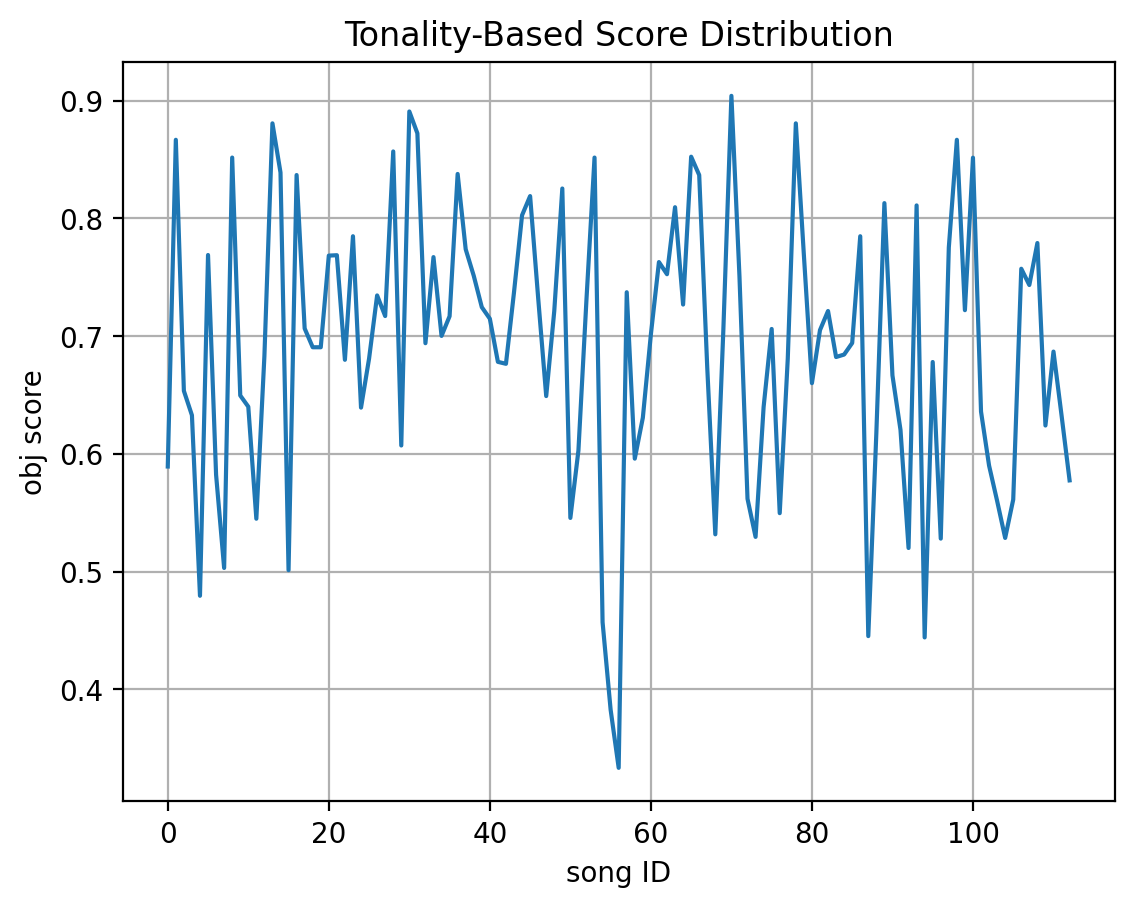

In [ ]:
def clean_special_characters(df, columns):
    for column in columns:
        if column in df.columns:
            df[column] = df[column].apply(lambda x: str(x).replace('♭', 'b') if isinstance(x, str) else x)
    return df


vocal_folder = 'test_audio/predict_result_vocal/'
target_folder = 'obj_score'

# Get a list of file names within the directory
files = os.listdir(vocal_folder)
sorted_files = sort_files(files)

# read excel
sheet_path = 'key_list/key_tunebat.xlsx'
tonality_list = pd.read_excel(sheet_path, usecols=[0, 1], nrows=len(files), header=None)
tonality_list.columns = ['Key', 'Mode']
tonality_list = clean_special_characters(tonality_list, ['Key'])

tonality_distribution = {}
note_distribution = {}  # record the note distribution among songs

obj_score = np.zeros(len(sorted_files))

# Loop through each file in the folder
for i, filename in enumerate(sorted_files):

    pitch_path = os.path.join(vocal_folder, filename)
    print(f'\nProcessing file: {pitch_path}')
    pitch = np.loadtxt(pitch_path)

    key = tonality_list.iloc[i, 0]
    mode = tonality_list.iloc[i, 1]
    print(f'ID {i+1}: tonality is {key} {mode}')

    update_dict(tonality_distribution, f'{key} {mode}')

    # obj_score[i] = compute_tonality_score(pitch, tonality_list[0][i])
    obj_score[i] = compute_tonality_score(pitch, key, mode, note_distribution, penalty=False)

    print(f'Normalized obj score: {obj_score[i]}')


# Show statistics
print(f'------------ Overall Statistics ---------------')
print(f'All songs obj score mean: {np.mean(obj_score)}\nAll songs obj score std: {np.std(obj_score)}')
# savefilepath = os.path.join(target_folder, 'tonality_score_model.txt')
savefilepath = os.path.join(target_folder, 'tonality_score_rtk.txt')
np.savetxt(savefilepath, obj_score)
print(f'{savefilepath} saved.')

# Plot pitch shifts
fig, ax = plt.subplots()
ax.plot(obj_score)
ax.set_xlabel('song ID')
ax.set_ylabel('obj score')
ax.set_title('Tonality-Based Score Distribution')
ax.grid()
plt.show()

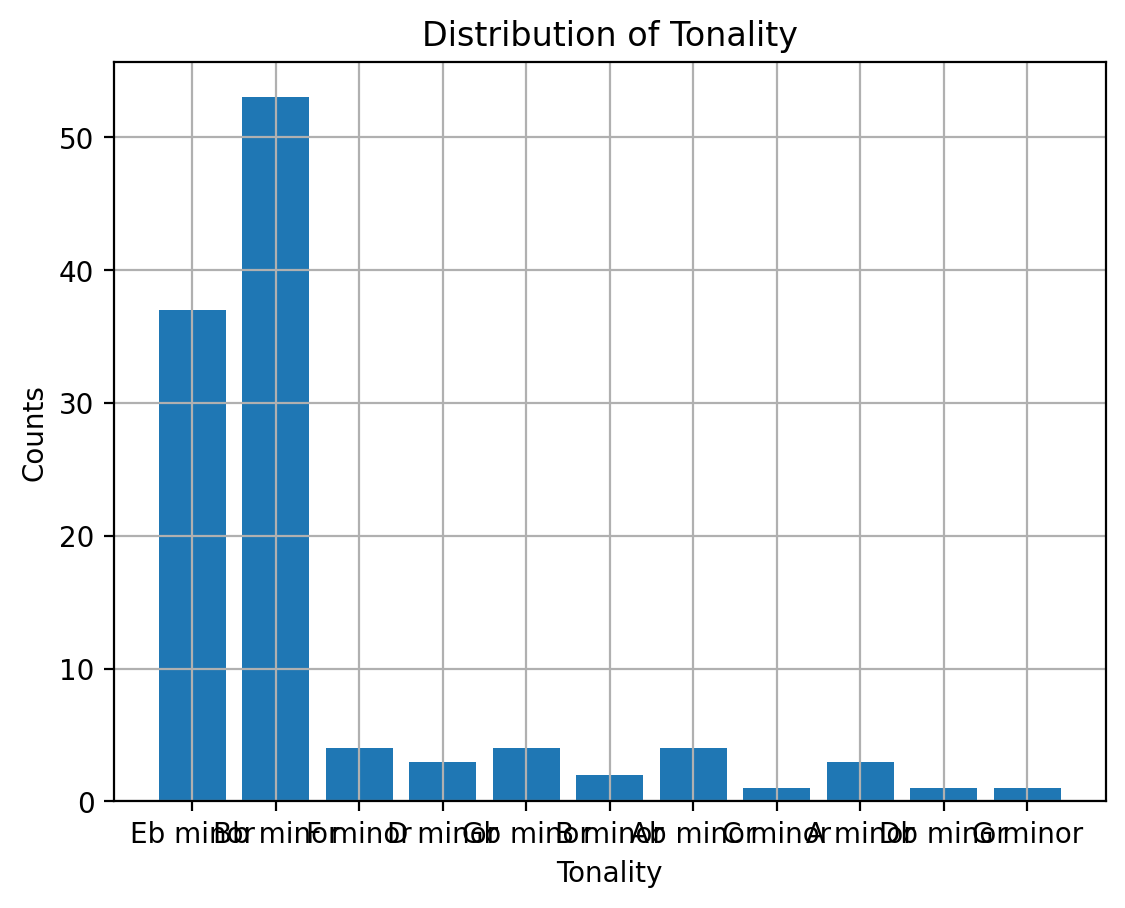

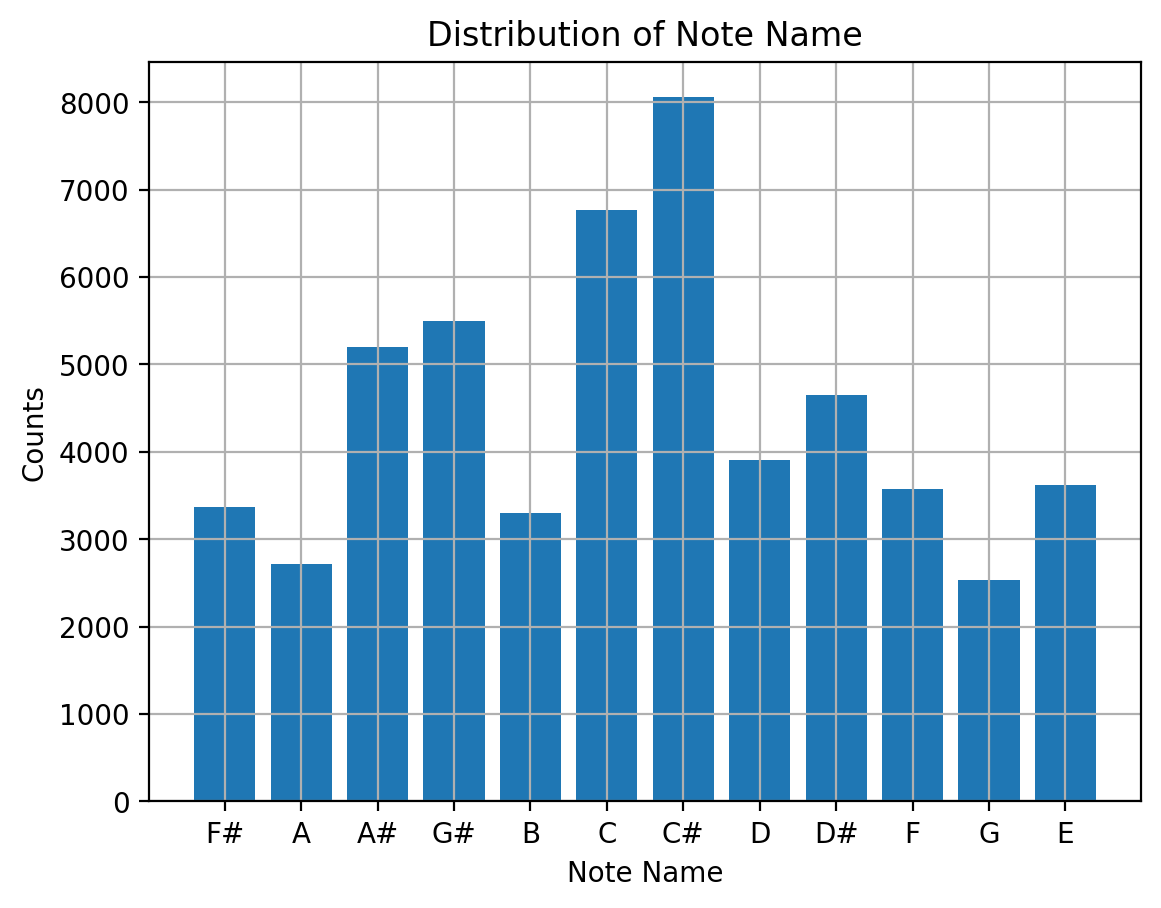

In [10]:
plot_dict_dist(tonality_distribution, 'Tonality')
plot_dict_dist(note_distribution, 'Note Name')

In [11]:
note_distribution

{'F#': 3368,
 'A': 2713,
 'A#': 5204,
 'G#': 5495,
 'B': 3297,
 'C': 6764,
 'C#': 8054,
 'D': 3905,
 'D#': 4646,
 'F': 3578,
 'G': 2539,
 'E': 3625}